## Import the relevant libraries

In [1]:
import pandas as pd
import numpy as np

import datetime
import calendar

from geopy.distance import vincenty
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#matplotlib display in notebook
%matplotlib inline 
#plotly output mode
init_notebook_mode(connected=True) 
#seaborn style
sns.set_style("whitegrid") 
sns.set_palette('deep')

## Import the data

In [2]:
df_station = pd.read_csv("station.csv")
df_trip = pd.read_csv("trip.csv")
df_weather = pd.read_csv("weather.csv")

## Lets do some data cleansing

**Clean trip zip_codes**

In [3]:
# set all invalid zips for non-subscribers to 00000
df_invalid_zips_cus = (df_trip['zip_code'].str.len()!=5) & (df_trip['subscription_type'].str.contains('Customer'))
df_trip.loc[df_invalid_zips_cus,'zip_code'] = '00000'

# add a zero to the beginning of the 4 digit subscriber zip codes
df_invalid_zips_sub_4 = '0' + df_trip[(df_trip['zip_code'].str.len()==4) & 
                                      (df_trip['subscription_type'].str.contains('Subscriber'))]['zip_code']
df_trip.loc[df_invalid_zips_sub_4.index,'zip_code'] = df_invalid_zips_sub_4

# truncate the long version zips
df_invalid_zips_sub_long = df_trip[df_trip['zip_code'].str.find('-')==5]['zip_code']
df_trip.loc[df_invalid_zips_sub_long.index,'zip_code'] = df_invalid_zips_sub_long.str.slice(0,5)

# set all remaining invalid zips for subscribers to 00000
df_invalid_zips_sub_rest = df_trip[df_trip['zip_code'].apply(lambda x: x.isnumeric()==False)]['zip_code']
df_trip.loc[df_invalid_zips_sub_rest.index,'zip_code'] = '00000'

**Clean other trip and station fields**

In [4]:
# Convert station IDs to string and add 'S' prefix
df_station['id'] = 'S'+ df_station['id'].astype(str)
df_trip['start_station_id'] = 'S' + df_trip['start_station_id'].astype(str)
df_trip['end_station_id'] = 'S' + df_trip['end_station_id'].astype(str)

# Convert trip IDs to string and add 'T' prefix
df_trip['id'] = 'T' + df_trip['id'].astype(str)

# Convert bike IDs to string and add 'B' prefix
df_trip['bike_id'] = 'B' + df_trip['bike_id'].astype(str)

# Convert trip start and end times to datetime
df_trip['start_date'] = pd.to_datetime(df_trip['start_date'])
df_trip['end_date'] = pd.to_datetime(df_trip['end_date'])

# Fix spelling error
df_trip.replace({'Kearney': 'Kearny'}, regex=True, inplace=True)

## Now we'll add some more features

In [5]:
# Get date features for trip
df_trip['trip_year'] = df_trip['start_date'].apply(lambda x: x.year)
df_trip['trip_monthtxt'] = df_trip['start_date'].apply(lambda x: calendar.month_abbr[x.month])
df_trip['trip_month'] = df_trip['start_date'].apply(lambda x: x.month)
df_trip['trip_dayofweek'] = df_trip['start_date'].apply(lambda x: calendar.day_abbr[x.dayofweek])
df_trip['trip_weekday'] = df_trip['start_date'].apply(lambda x: x.dayofweek)
df_trip['trip_hour'] = df_trip['start_date'].apply(lambda x: x.hour)
df_trip['trip_day'] = df_trip['start_date'].apply(lambda x: x.day)
df_trip['trip_date'] = df_trip['start_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [6]:
# Bike returned to same location?
df_trip['return_same_location'] = df_trip['start_station_id'] == df_trip['end_station_id']
df_trip['return_same_location'] = df_trip['return_same_location'].apply(lambda x: 1 if x else 0)

# Set duration to 0 where trip is longer than 12 hours (probably indicates the bike was stolen so its not a real trip)
df_invalid_trip_dur = df_trip['duration'] > 43200
df_trip.loc[df_invalid_trip_dur,'duration'] = 0

In [7]:
# Extra cost per trip (>30mins for "Customer", >45 mins for "Subscriber")
df_trip['extra_cost'] = 0
extra_cost_cust = (df_trip['subscription_type'] == 'Customer') & (df_trip['duration'] > 1800) 
df_trip['extra_cost_cust'] = df_trip[extra_cost_cust]['duration'].apply(lambda x: (((x-1800) // 900)+1) *3)
extra_cost_sub = (df_trip['subscription_type'] == 'Subscriber') & (df_trip['duration'] > 2700) 
df_trip['extra_cost_sub'] = df_trip[extra_cost_sub]['duration'].apply(lambda x: (((x-2700) // 900)+1) *3)
df_trip.loc[:,'extra_cost_cust'] = df_trip.loc[:,'extra_cost_cust'].fillna(0)
df_trip.loc[:,'extra_cost_sub'] = df_trip.loc[:,'extra_cost_sub'].fillna(0)
df_trip['extra_cost'] = df_trip['extra_cost_cust'] + df_trip['extra_cost_sub']

In [8]:
# change zip to city to map weather to trips
zip_to_city = ({'zip_code': 
                {95113:'San Jose',94041:'Mountain View',94301:'Palo Alto',94063:'Redwood City', 94107:'San Francisco'}})

for key, value in zip_to_city.items():
    df_weather[key] = df_weather[key].replace(value)

df_weather.rename(columns={'zip_code':'weather_city'}, inplace=True)

#fix Rain indicator based on precipitation inches
df_weather["Rain"] = df_weather["precipitation_inches"].apply(lambda x: 1 if x>0 else 0)

#fix weather date
df_weather["date"] = pd.to_datetime(df_weather["date"]).apply(lambda x: x.strftime('%Y-%m-%d'))

In [9]:
# Make new dataframe with station info
df_trip_station = pd.merge(df_trip, df_station, left_on='start_station_id', right_on='id')
df_trip_station = pd.merge(df_trip_station, df_station, left_on='end_station_id', right_on='id')

# remove unnecessary columns 
df_trip_station['start_station_lat'] = df_trip_station['lat_x']
df_trip_station['start_station_long'] = df_trip_station['long_x']
df_trip_station['start_station_dock_count'] = df_trip_station['dock_count_x']
df_trip_station['start_station_city'] = df_trip_station['city_x']
df_trip_station['start_station_installation_date'] = df_trip_station['installation_date_x']
df_trip_station['end_station_lat'] = df_trip_station['lat_y']
df_trip_station['end_station_long'] = df_trip_station['long_y']
df_trip_station['end_station_dock_count'] = df_trip_station['dock_count_y']
df_trip_station['end_station_city'] = df_trip_station['city_y']
df_trip_station['end_station_installation_date'] = df_trip_station['installation_date_y']

df_trip_station.drop(['id','id_y','lat_x','long_x','dock_count_x','city_x','installation_date_x', 
                      'name_x', 'name_y','lat_y','long_y','dock_count_y','city_y',
                      'installation_date_y'], axis=1, inplace=True)

In [10]:
# add weather info
df_trip_station = pd.merge(df_trip_station, df_weather, how='left',
                           left_on=['start_station_city','trip_date'], right_on=['weather_city', 'date'])

In [11]:
# Did ride start and end in the same city?
df_trip_station['return_same_city'] = df_trip_station['start_station_city'] == df_trip_station['end_station_city']
df_trip_station['return_same_city'] = df_trip_station['return_same_city'].apply(lambda x: 1 if x else 0)

In [12]:
# Distance between start and end stations
df_trip_station['distance'] = df_trip_station.apply(lambda x: vincenty((x['start_station_lat'], x['start_station_long']),
                                      (x['end_station_lat'], x['end_station_long'])).miles, axis=1)

In [13]:
# reset the df_trip dataframe to conserve memory
df_trip = pd.DataFrame()

In [14]:
# add a count column to aid in charting
df_trip_station['count'] = 1

## Alright, let's see what this data looks like it plot form

Text(0.5,0.98,'Trips started per station')

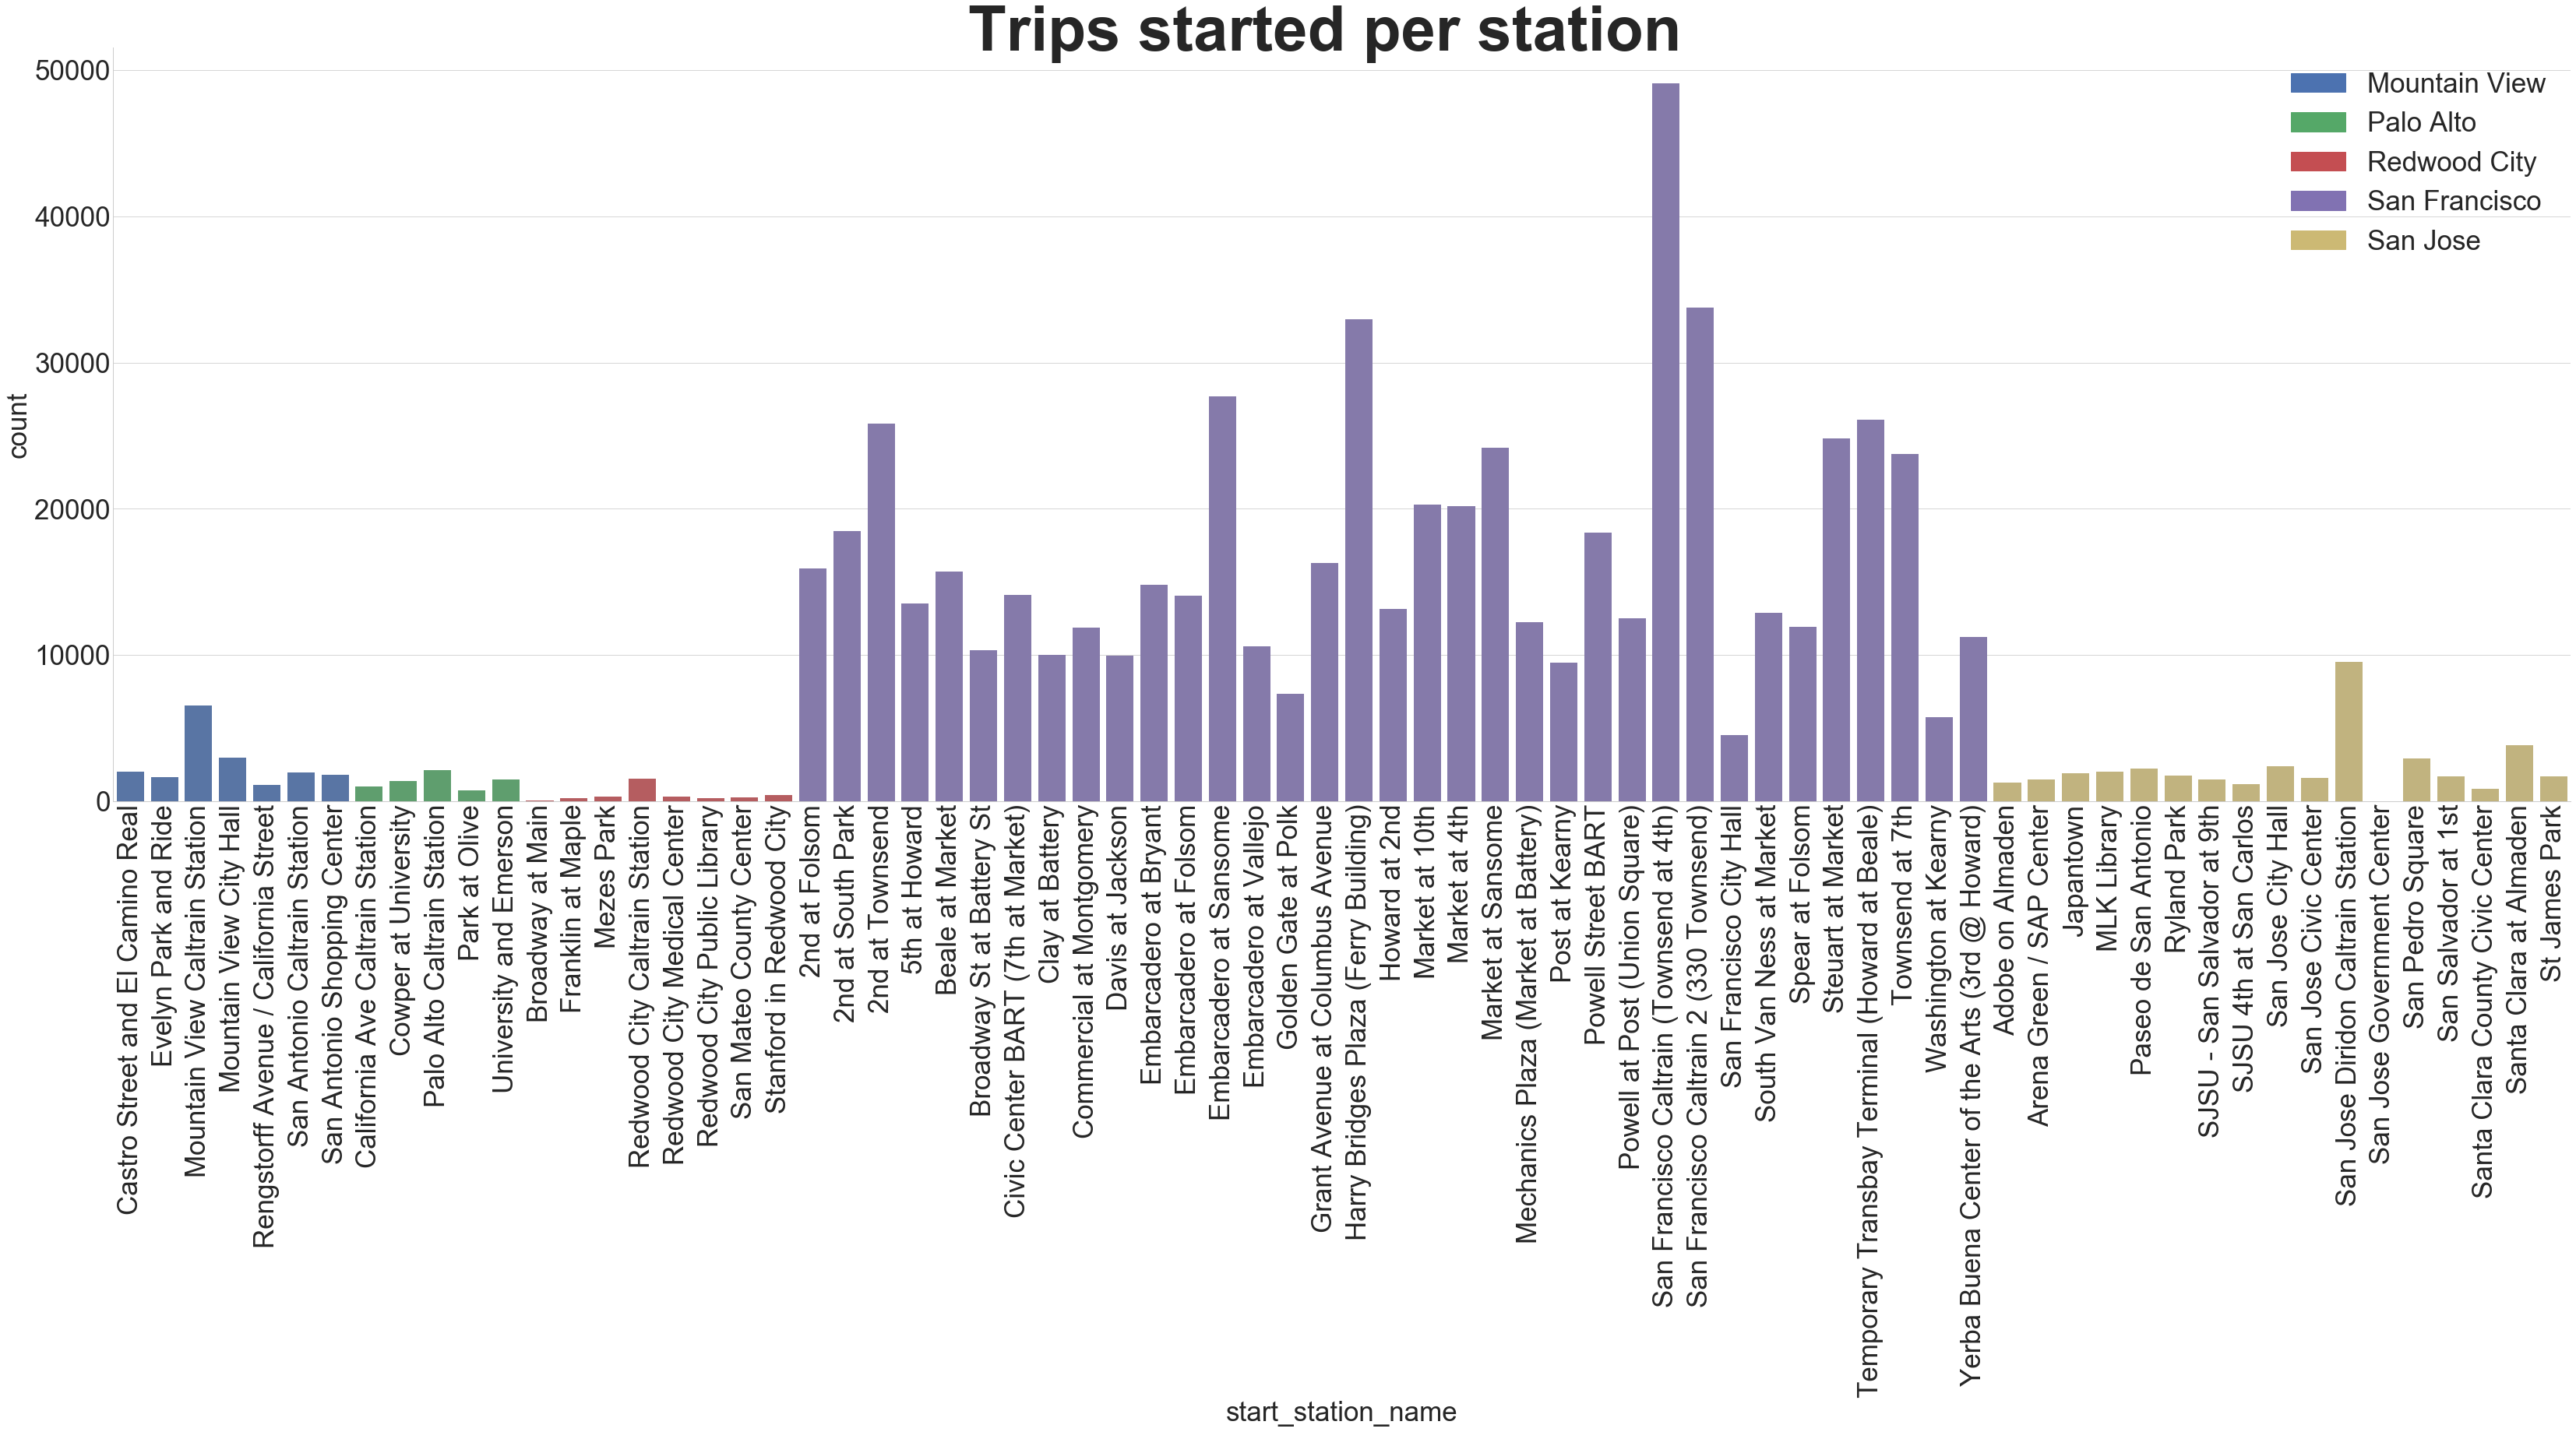

In [19]:
# plot trips started per station
station_trip_count = df_trip_station.groupby(['start_station_city','start_station_name'], as_index=False)['count'].sum()
cities = station_trip_count['start_station_city'].unique()
cities = pd.Series(sns.color_palette("deep")[:len(cities)], index=cities)
cities = cities.to_dict()
g = sns.factorplot(x='start_station_name', y='count', data=station_trip_count,
                   estimator=np.sum, size=15, aspect=3, palette=station_trip_count['start_station_city'].map(cities), 
                   kind='bar')
g.set_xticklabels(rotation=90)
g.ax.tick_params(axis='both', which='major', labelsize=35)
g.set_xlabels(fontsize=35)
g.set_ylabels(fontsize=35)
# make legend for cities
legend = []
i=0
for x in cities:
    legend.append(mpatches.Patch(color=cities[x], label=x))
g.ax.legend(handles=legend, fontsize=35)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Trips started per station',fontsize=80,fontweight='bold')


Text(0.5,0.98,'Trips started per city by hour of the day')

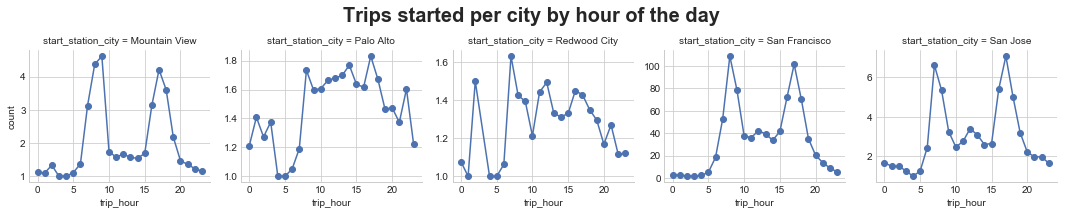

In [22]:
# City comparison
average_count = df_trip_station.groupby(['start_station_city','trip_date','trip_hour'], as_index=False)['count'].sum()
average_count = average_count.groupby(['start_station_city','trip_hour'], as_index=False)['count'].mean()
grid = sns.FacetGrid(average_count,col='start_station_city', sharey=False)

grid.map(plt.plot, "trip_hour", "count", marker="o", ms=6).add_legend()
grid.fig.subplots_adjust(top=0.78)
grid.fig.suptitle('Trips started per city by hour of the day',fontsize=20,fontweight='bold')

### Findings

- SF is the only city that we can rely on for useful analysis. Other cities just don't have the volume

## In that case, let's just filter our results by those trips taken in San Francisco

In [62]:
df_trip_station_SF = df_trip_station[df_trip_station['start_station_city']=='San Francisco'].copy()

**First we'll plot some graphs related to trip duration**

Text(0.5,0.98,'Trips returned to same station by station')

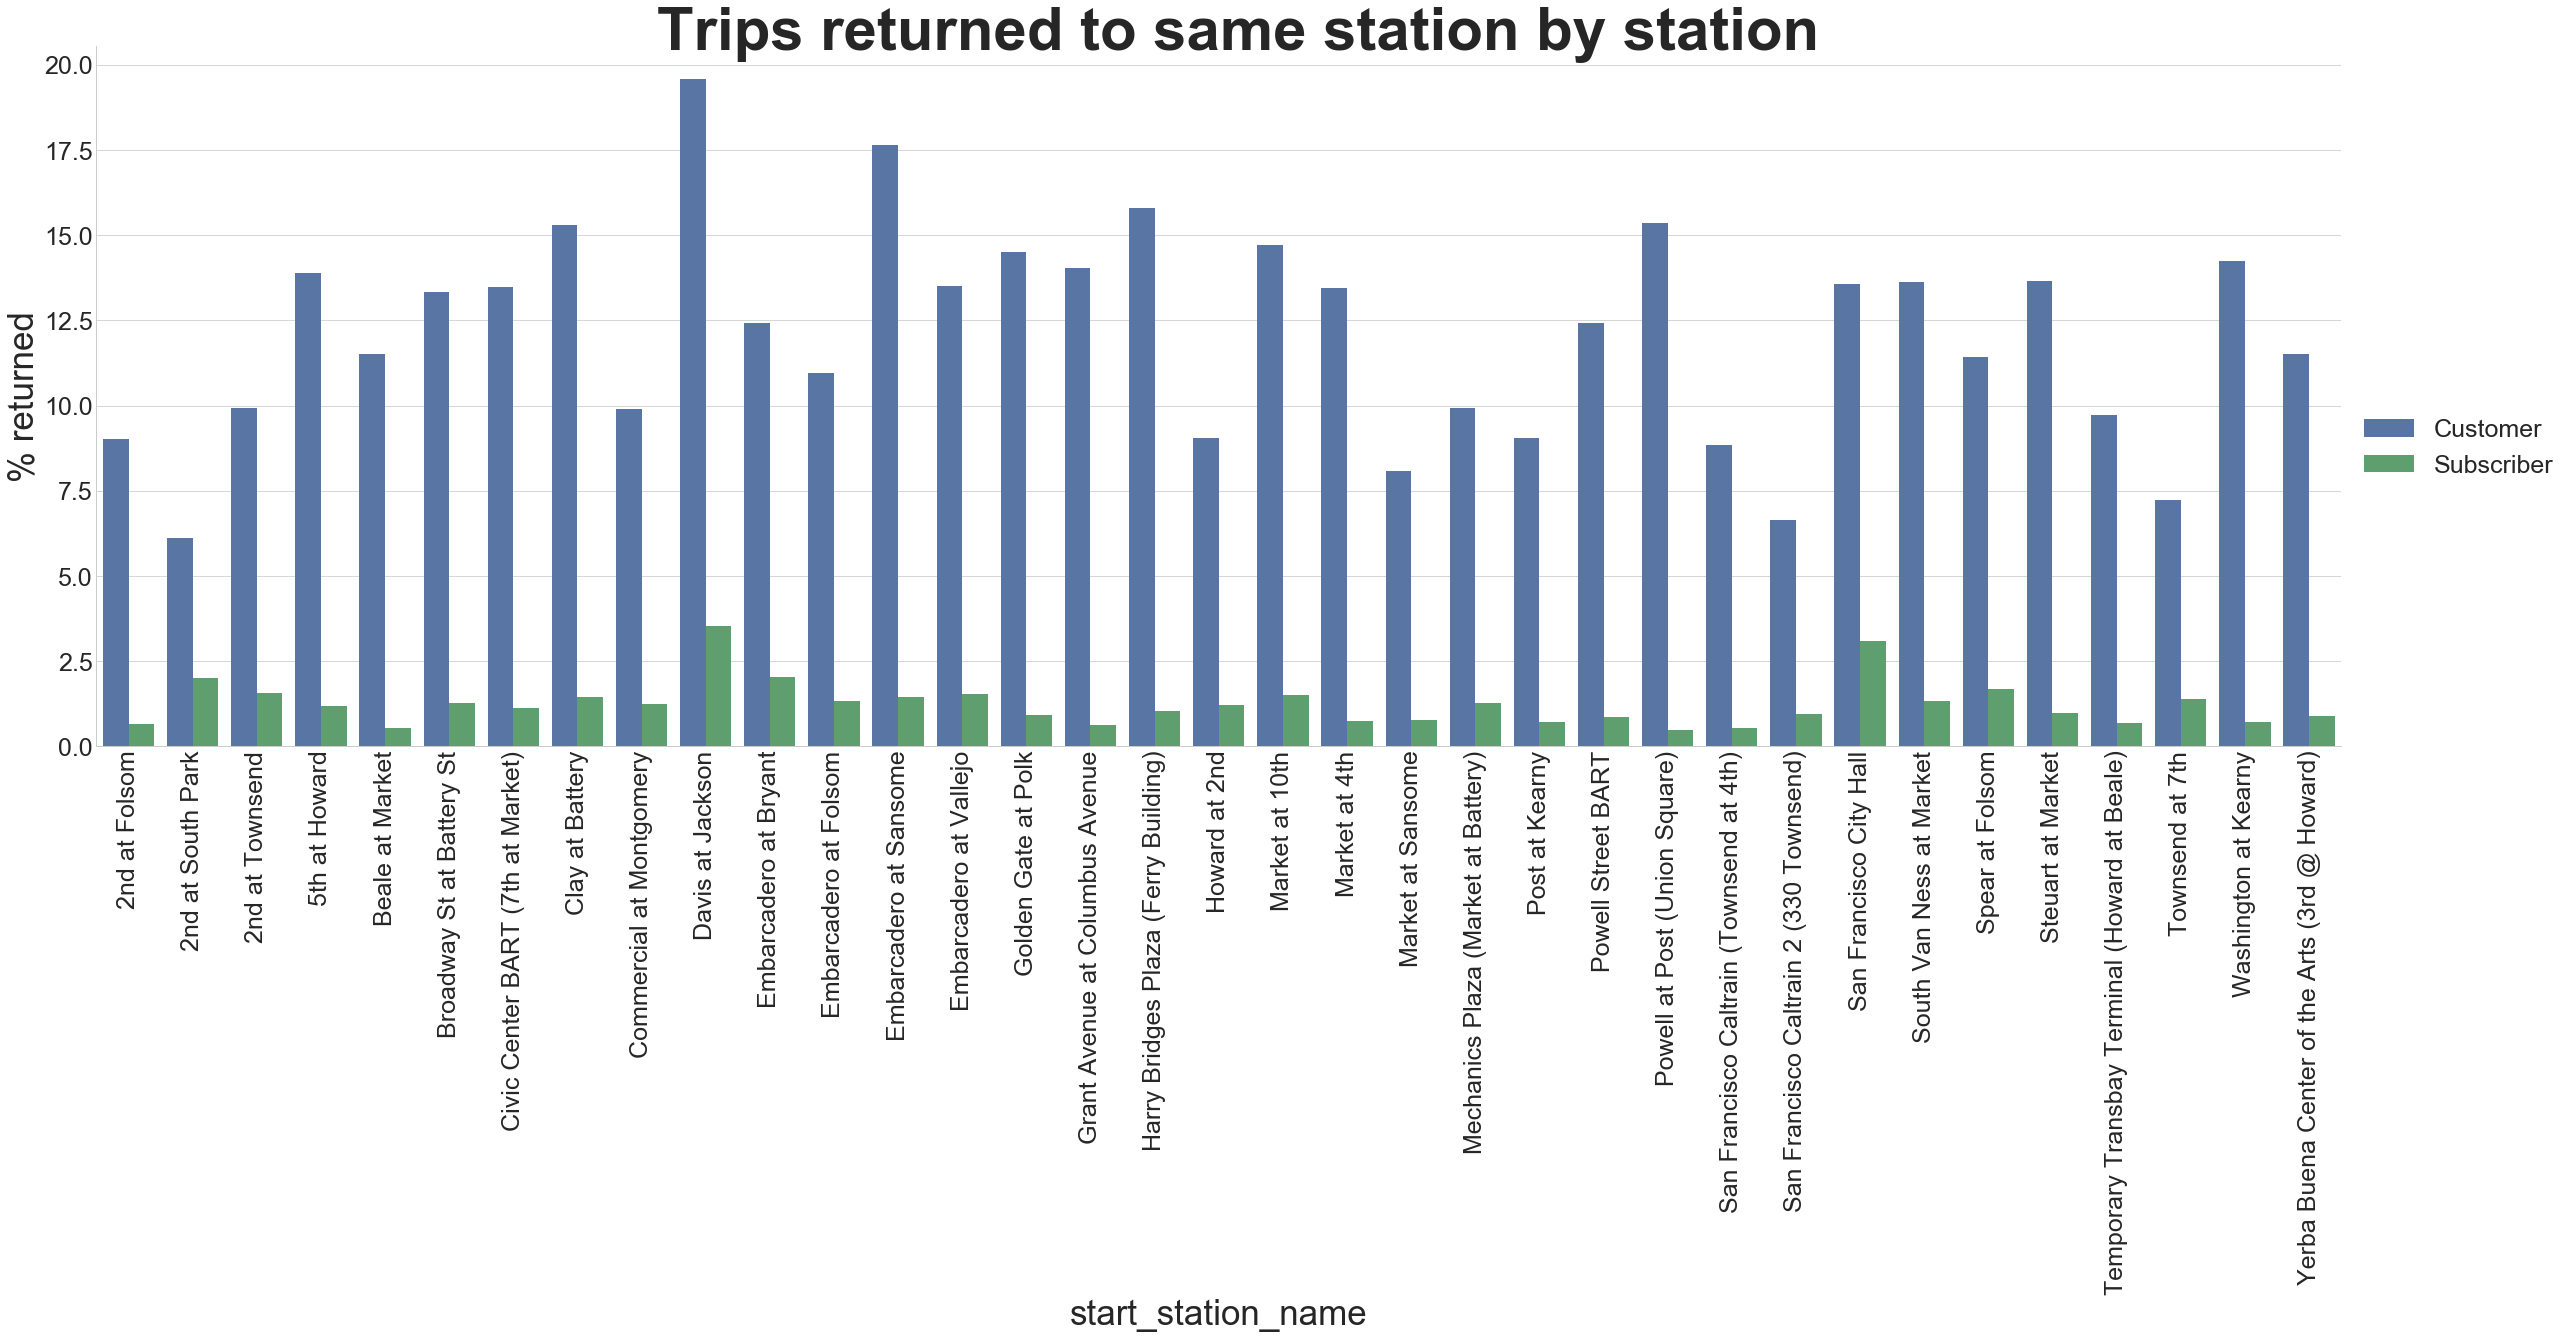

In [45]:
# plot % of trips returned to same station per station
station_trip_count = df_trip_station_SF.groupby(['start_station_name', 'subscription_type'], as_index=False)['count'].sum()
station_not_returned = df_trip_station_SF[df_trip_station_SF['return_same_location']==0].groupby(['start_station_name','subscription_type'], as_index=False)['count'].sum()
station_not_returned['count'] = 100 - station_not_returned['count'] / station_trip_count['count'] *100

g = sns.factorplot(x='start_station_name', y='count', data=station_not_returned, hue='subscription_type', legend=False,
                   estimator=np.sum, size=11, aspect=3, kind='bar')
g.set_xticklabels(rotation=90)
g.ax.tick_params(axis='both', which='major', labelsize=25)
g.set_xlabels(fontsize=35)
g.set_ylabels(label='% returned',fontsize=35)
g.ax.legend(fontsize=25, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Trips returned to same station by station',fontsize=60,fontweight='bold')

Text(0.5,0.98,'Trip duration average by station')

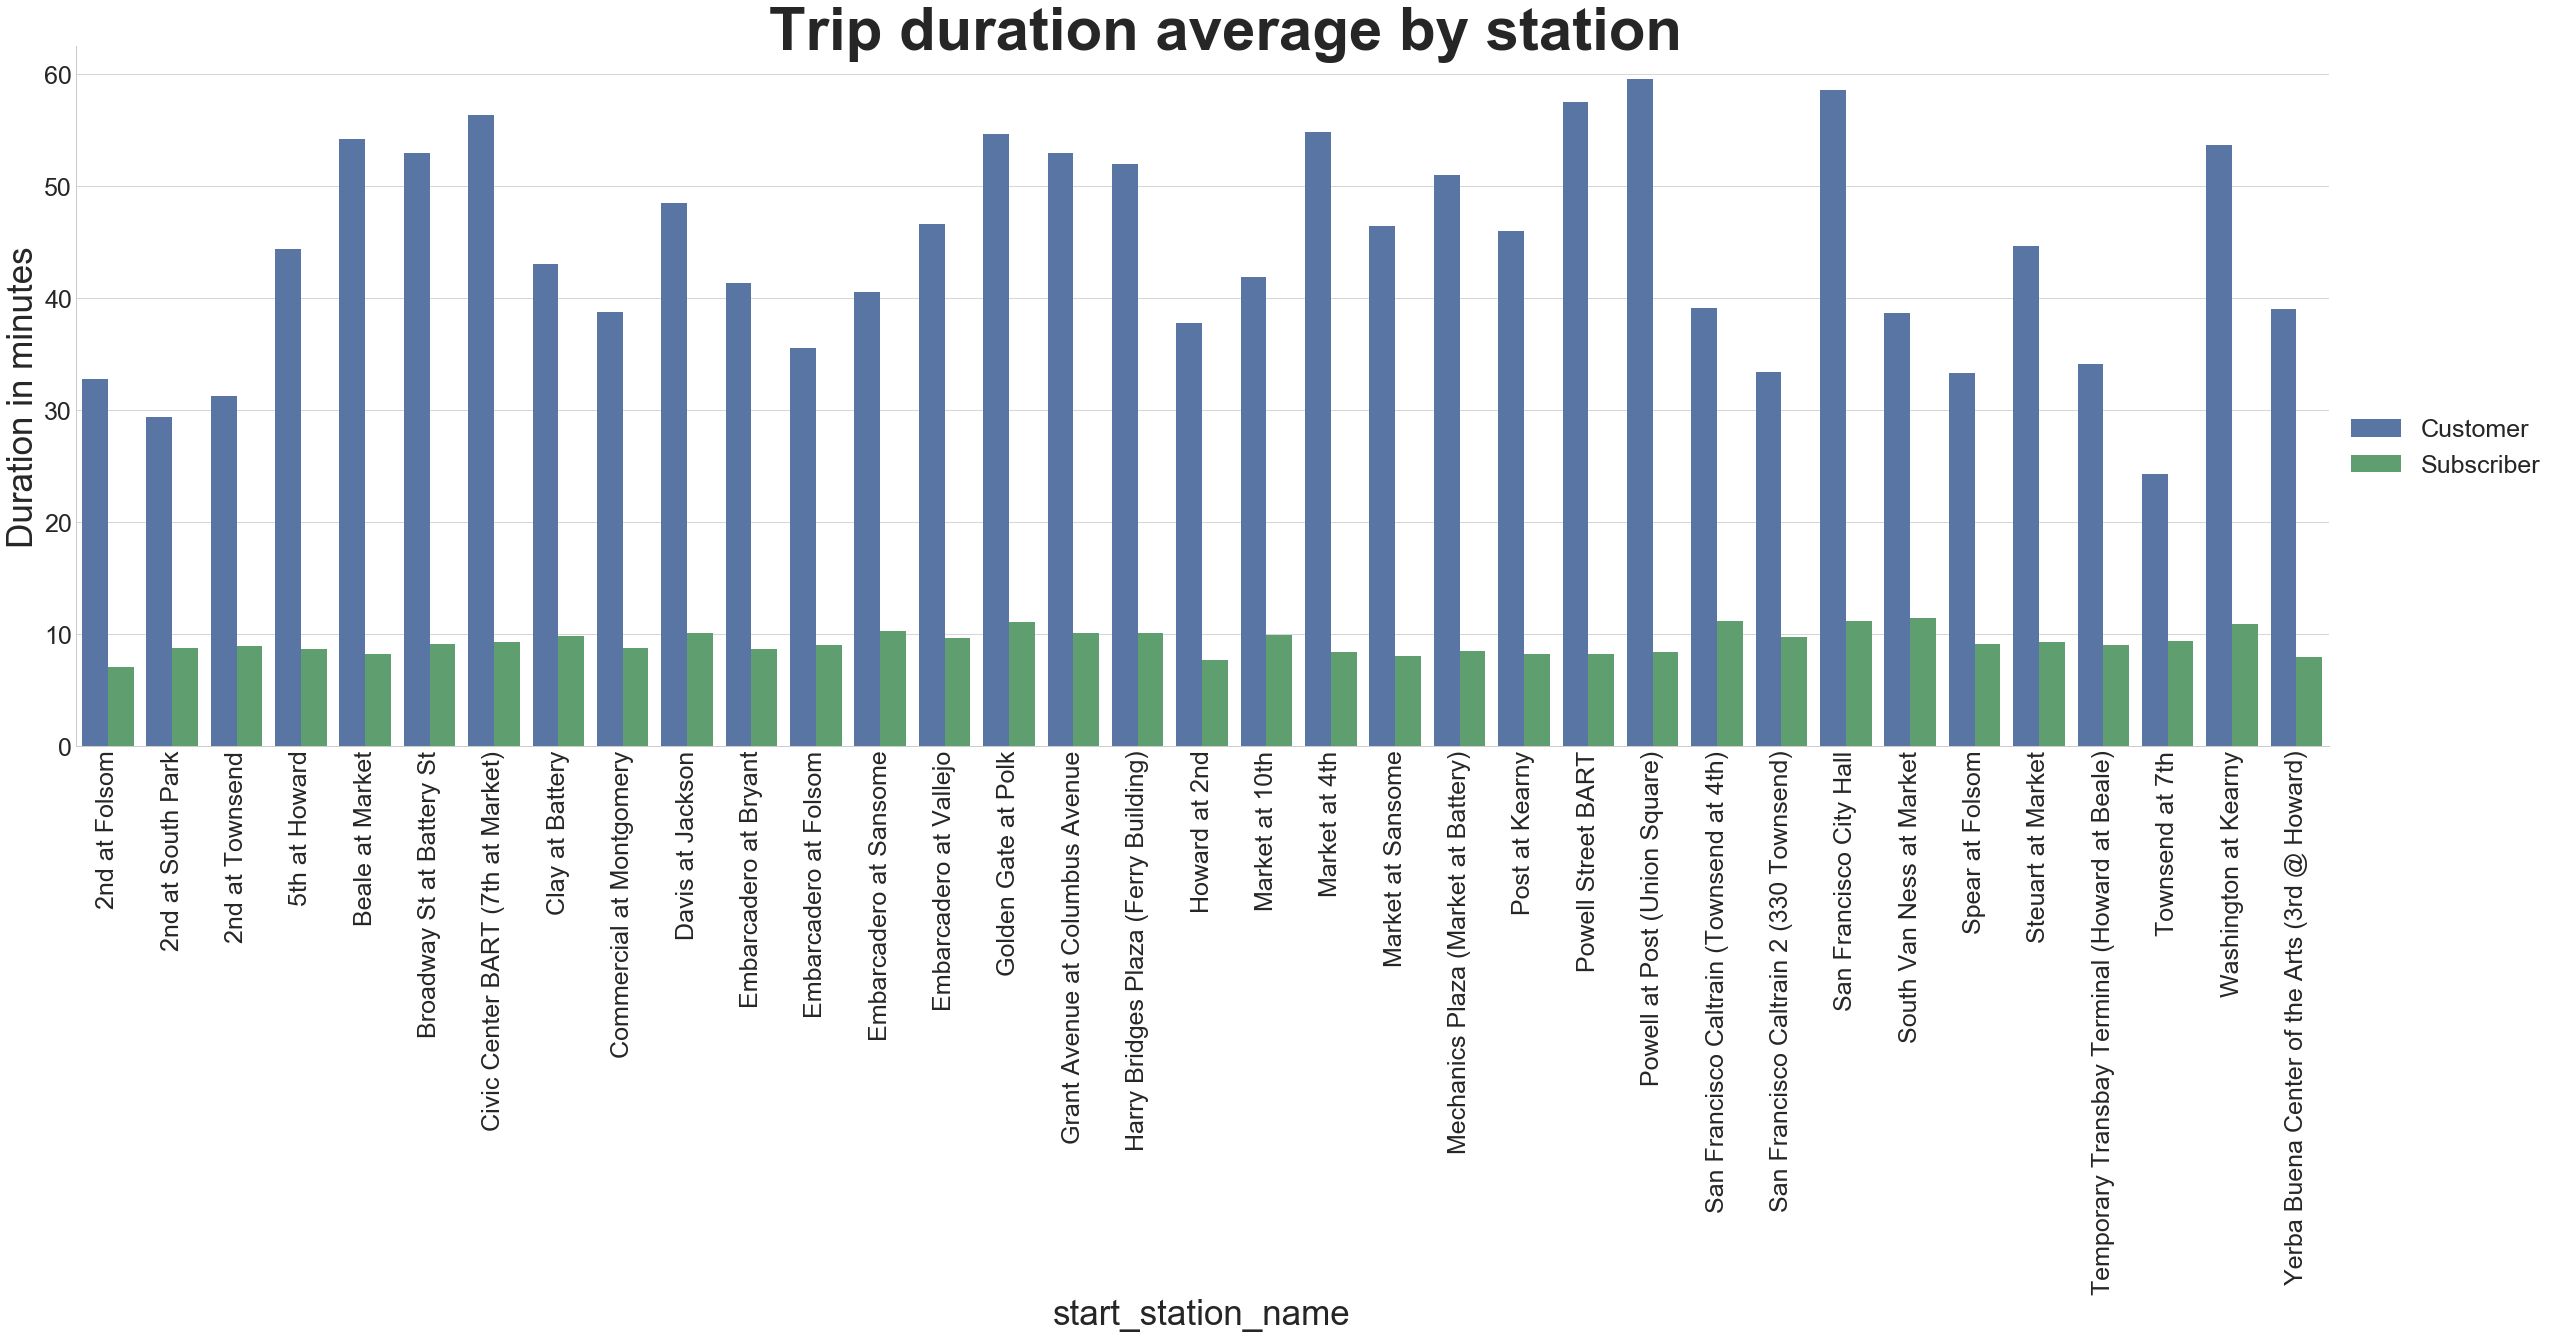

In [46]:
# plot trip duration average per station
station_trip_duration = df_trip_station_SF.groupby(['start_station_name', 'subscription_type'], as_index=False)['duration'].mean()
station_trip_duration['duration'] = station_trip_duration['duration']/60

g = sns.factorplot(x='start_station_name', y='duration', data=station_trip_duration, hue='subscription_type', legend=False,
                   estimator=np.sum, size=11, aspect=3, kind='bar')
g.set_xticklabels(rotation=90)
g.ax.tick_params(axis='both', which='major', labelsize=25)
g.set_xlabels(fontsize=35)
g.set_ylabels(label='Duration in minutes',fontsize=35)
g.ax.legend(fontsize=25, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Trip duration average by station',fontsize=60,fontweight='bold')

Text(0.5,0.98,'Customer vs subscriber trip durations for SF')

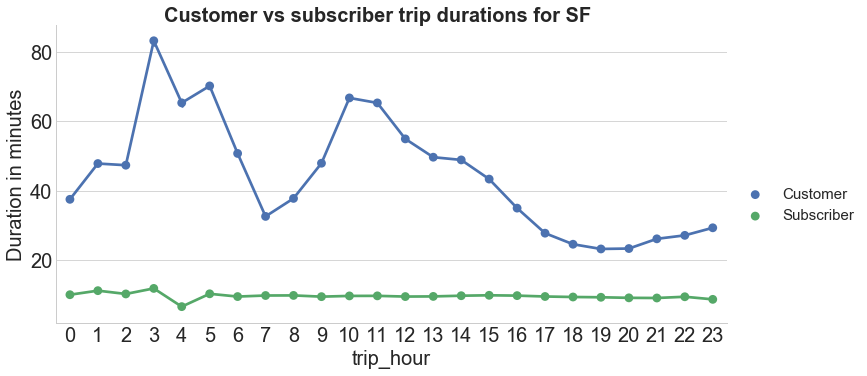

In [47]:
# Customer vs subscriber durations for SF
# Customers enjoy much longer rides than subscribers
average_duration = df_trip_station_SF.groupby(['subscription_type','trip_date','trip_hour'], as_index=False)['duration'].mean()
average_duration['duration'] = average_duration['duration']/60
g = sns.factorplot(x='trip_hour', y='duration', data=average_duration, legend=False,
                   size=5, aspect=2, hue='subscription_type', ci=1,
                   kind='point')
g.ax.tick_params(axis='both', which='major', labelsize=20)
g.set_xlabels(fontsize=20)
g.set_ylabels(label='Duration in minutes', fontsize=20)
g.ax.legend(fontsize=15, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Customer vs subscriber trip durations for SF',fontsize=20,fontweight='bold')


**Now some plots relating to trip time and day of the week**

Text(0.5,0.98,'Customer vs subscriber counts by hour for SF')

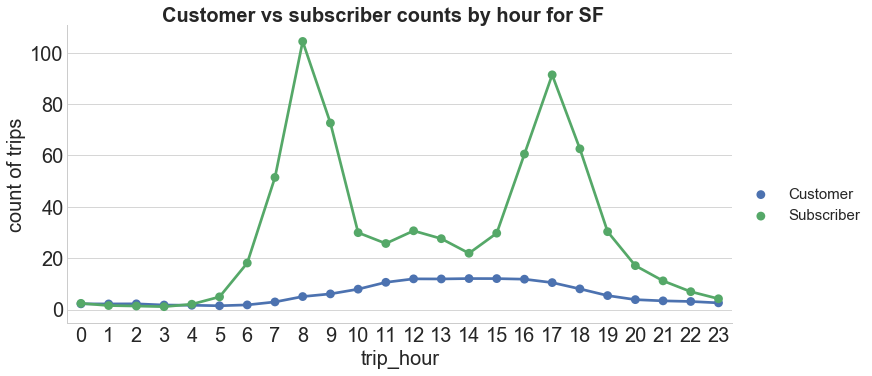

In [82]:
# Customer vs subscriber counts by hour for SF
average_count = df_trip_station_SF.groupby(['subscription_type','trip_date','trip_hour'], as_index=False)['count'].sum()

g = sns.factorplot(x='trip_hour', y='count', data=average_count, legend=False,
                   size=5, aspect=2, hue='subscription_type', ci=1,
                   kind='point')
g.ax.tick_params(axis='both', which='major', labelsize=20)
g.set_xlabels(fontsize=20)
g.set_ylabels(label='count of trips', fontsize=20)
g.ax.legend(fontsize=15, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle('Customer vs subscriber counts by hour for SF',fontsize=20,fontweight='bold')

Text(0.5,0.98,'Customer vs subscriber trip counts by weekday')

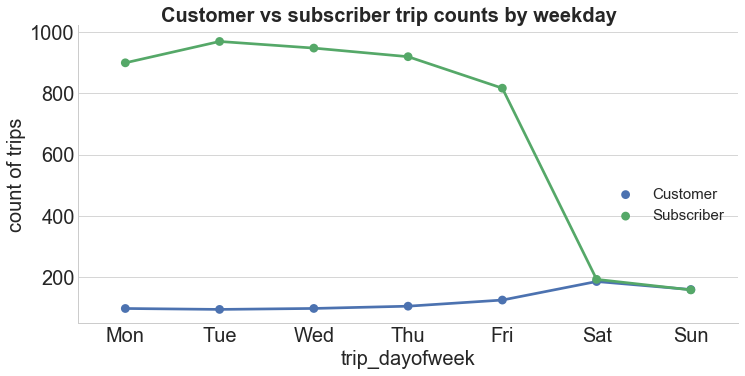

In [50]:
# Customer vs subscriber counts by weekday
average_count = df_trip_station_SF.groupby(['subscription_type','trip_date','trip_dayofweek'], as_index=False)['count'].sum()

g = sns.factorplot(x='trip_dayofweek', y='count', data=average_count, legend=False, ci=1,
                   size=5, aspect=2, hue='subscription_type', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                   kind='point')
g.ax.tick_params(axis='both', which='major', labelsize=20)
g.set_xlabels(fontsize=20)
g.set_ylabels(label='count of trips', fontsize=20)
g.ax.legend(fontsize=15, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle ('Customer vs subscriber trip counts by weekday',fontsize=20,fontweight='bold')

### Findings

- Users without a subscription ("customers") are more likely to perform round trips where they return bikes to the same station.
- Subscribers almost exclusively perform point to point trips. 
- Ad hoc users also enjoy much longer rides on average than subscribers. 
- Subscribers consistently hover around the 10 minute length whereas customers fluctuate considerably depending on the time of day. 
    - Hour-long trips in the middle of the day
    - Shorter trips in the evenings
    - Long trips in the early hours of the morning. Could this be due to drunk people having fun? Or a lack of data points?
- Subscriber trips have dramatic peaks around the rush hour periods in the mornings and evenings
- While subscribers are 9 times more likely to use the service during weekdays usage on the weekends is comparable to the ad hoc customers

This suggests ad hoc users use the service more for leisure trips and compared to subscribers, who use the system for primarily for commuting

## Does the weather make a difference to the number of trips taken?

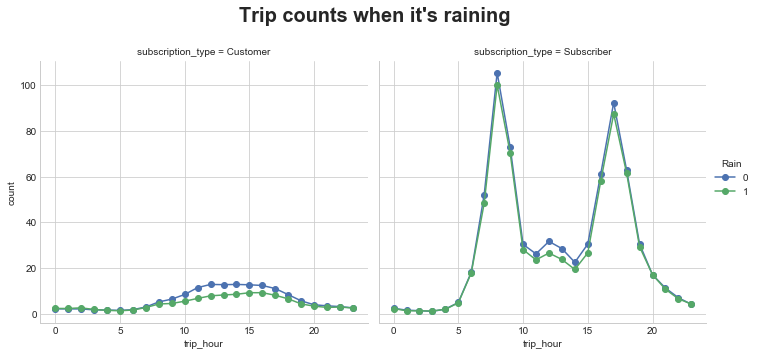

In [51]:
# Rain vs no rain counts for SF
average_count = df_trip_station_SF.groupby(['subscription_type','trip_date','Rain','trip_hour'], as_index=False)['count'].sum()
average_count = average_count.groupby(['subscription_type','Rain','trip_hour'], as_index=False)['count'].mean()
g = sns.FacetGrid(average_count, col='subscription_type',hue='Rain', size=5)
g.map(plt.plot, "trip_hour", "count", marker="o", ms=6)
g.fig.subplots_adjust(top=0.83)
g.fig.suptitle ("Trip counts when it's raining",fontsize=20,fontweight='bold')
g.add_legend()


In [52]:
# Set the monthly mean to determine if its hotter or colder than average
monthly_means=df_trip_station_SF.groupby(['trip_month']).mean()


In [63]:
df_trip_station_SF["mean_temperature_f_month"]= df_trip_station_SF["trip_month"].apply(lambda x: monthly_means.loc[x,"mean_temperature_f"])
df_trip_station_SF["mean_temperature_f_colder"] = df_trip_station_SF["mean_temperature_f_month"]>df_trip_station_SF["mean_temperature_f"]

df_trip_station_SF["max_temperature_f_month"]= df_trip_station_SF["trip_month"].apply(lambda x: monthly_means.loc[x,"max_temperature_f"])
df_trip_station_SF["max_temperature_f_colder"] = df_trip_station_SF["max_temperature_f_month"]>df_trip_station_SF["max_temperature_f"]

df_trip_station_SF["min_temperature_f_month"]= df_trip_station_SF["trip_month"].apply(lambda x: monthly_means.loc[x,"min_temperature_f"])
df_trip_station_SF["min_temperature_f_colder"] = df_trip_station_SF["min_temperature_f_month"]>df_trip_station_SF["min_temperature_f"]

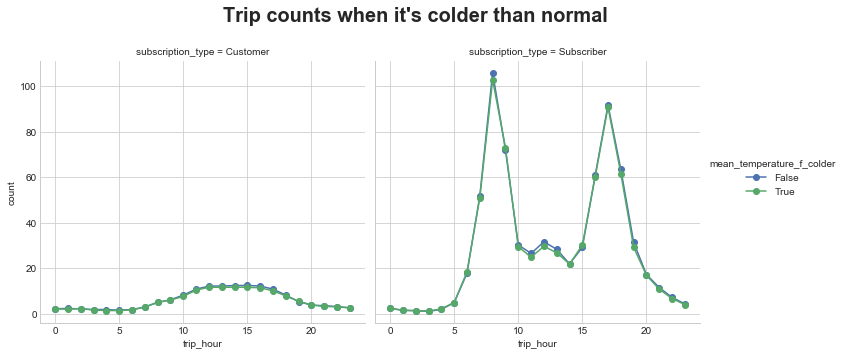

In [54]:
# Cold vs warm counts for SF

average_count = df_trip_station_SF.groupby(['subscription_type','trip_date','mean_temperature_f_colder','trip_hour'], as_index=False)['count'].sum()
average_count = average_count.groupby(['subscription_type','mean_temperature_f_colder','trip_hour'], as_index=False)['count'].mean()
g = sns.FacetGrid(average_count,col='subscription_type', hue='mean_temperature_f_colder', size=5)
g.map(plt.plot, "trip_hour", "count", marker="o", ms=6)
g.fig.subplots_adjust(top=0.83)
g.fig.suptitle ("Trip counts when it's colder than normal",fontsize=20,fontweight='bold')
g.add_legend()


### Findings

- When it is raining there is a slight decrease in trips for subscribers; relatively bigger difference for customers
- The relative temperature does not cause much difference in ridership

Text(0.5,0.98,'Trips that incurred an extra cost')

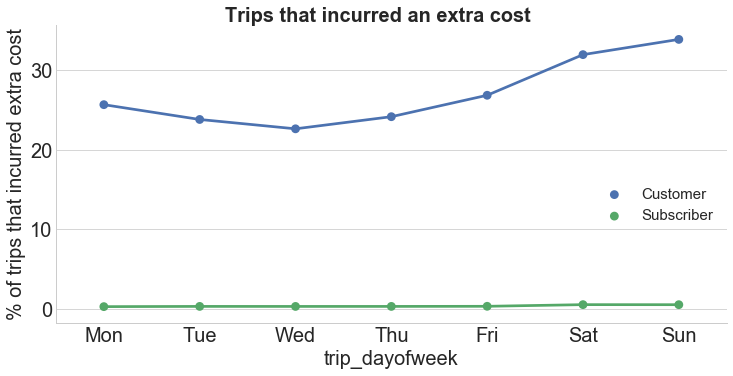

In [71]:
df_trip_station_SF['extra_cost_flag'] = df_trip_station_SF.extra_cost.apply(lambda x: True if x>0 else False)
extra_cost_trips = df_trip_station_SF.groupby(['subscription_type','trip_dayofweek'], as_index=False)['extra_cost_flag'].mean()
extra_cost_trips['extra_cost_flag'] = extra_cost_trips['extra_cost_flag']*100
g = sns.factorplot(x='trip_dayofweek', y='extra_cost_flag', data=extra_cost_trips, legend=False,
                   size=5, aspect=2, hue='subscription_type', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                   kind='point')
g.ax.tick_params(axis='both', which='major', labelsize=20)
g.set_xlabels(fontsize=20)
g.set_ylabels(label='% of trips that incurred extra cost', fontsize=20)
g.ax.legend(fontsize=15, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle ("Trips that incurred an extra cost",fontsize=20,fontweight='bold')

Text(0.5,0.98,'Mean extra trip cost by week day and customer vs. subscriber')

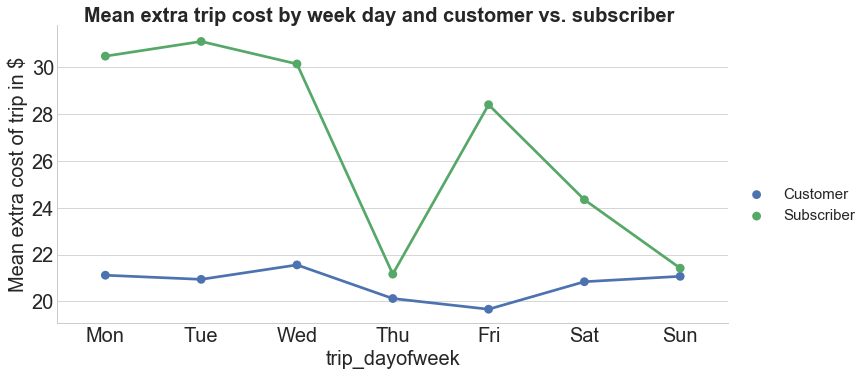

In [55]:
# Extra costs by weekday
df_trip_station_SF_extra = df_trip_station_SF[df_trip_station_SF['extra_cost']>0]
average_cost = df_trip_station_SF_extra.groupby(['subscription_type','trip_dayofweek'], as_index=False)['extra_cost'].mean()
g = sns.factorplot(x='trip_dayofweek', y='extra_cost', data=average_cost, legend=False,
                   size=5, aspect=2, hue='subscription_type', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                   kind='point')
g.ax.tick_params(axis='both', which='major', labelsize=20)
g.set_xlabels(fontsize=20)
g.set_ylabels(label='Mean extra cost of trip in $', fontsize=20)
g.ax.legend(fontsize=15, bbox_to_anchor=(1,.5))
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle ("Mean extra trip cost by week day and customer vs. subscriber",fontsize=20,fontweight='bold')

### Findings

- While subscribers rarely incurred extra costs for their trips, when they did the total per trip averaged up to 50% more than ad hoc customers
- Trips on the weekend were more likely to incur an extra cost
- Unsure what causes the downward spike in subscriber average cost on Thursday. Potentially lack of data?

## Let's try plotting with Plotly rather than Seaborn

In [73]:
#What hours are busiest for SF stations?
df = df_trip_station_SF.groupby(['start_station_name', 'trip_date', 'trip_hour'],as_index=False)['count'].sum()
df = df.groupby(['start_station_name', 'trip_hour'],as_index=False)['count'].mean()
data = [
    go.Heatmap(
        z=df['count'],
        x=df['trip_hour'],
        y=df['start_station_name'],
        colorscale='Hot',
        reversescale=True,
        colorbar=dict(title='Average trips per hour')
    )
]
layout = go.Layout(
    title='What hours are busiest for SF stations?',
    height=900,
    width=1000,
    margin=dict(l=250),
    xaxis = dict(ticks='',nticks=25),
    yaxis = dict(ticks='',tickfont = dict(size=10))
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Findings

- 3 or 4 stations take most of the trip load

### Now we'll plot some of these trips on a map

**Plot with Basemap - not very good for small areas eg/ city and looks pretty ugly**

C:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.

C:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning:

The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.



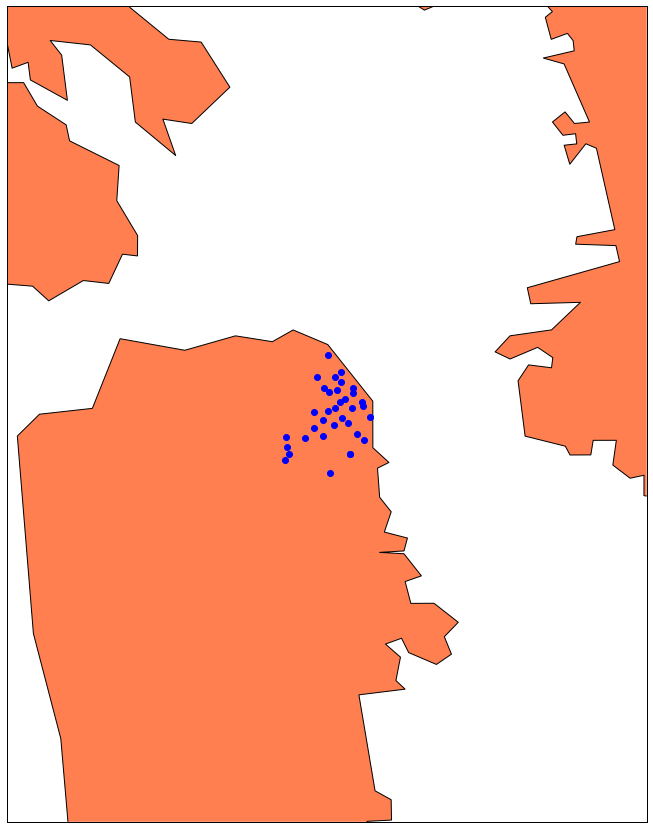

In [75]:
# plot with Basemap - not very good for small areas eg/ city and looks pretty ugly
df_stations_SF = df_station[df_station['city']=='San Francisco']

maxlat = df_stations_SF['lat'].max()
maxlong = df_stations_SF['long'].max()
minlat = df_stations_SF['lat'].min()
minlong = df_stations_SF['long'].min()
plt.figure(figsize=(20,15))
map = Basemap(
    projection='tmerc',
    lon_0=-122.398108,
    lat_0=37.786978,
    ellps = 'WGS84',
    llcrnrlon=minlong-.1,
    llcrnrlat=minlat-.1,
    urcrnrlon=maxlong+.1,
    urcrnrlat=maxlat+.1,
    lat_ts=0,
    resolution='h',
    suppress_ticks=True)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
map.plot(list(df_stations_SF['long']), list(df_stations_SF['lat']), 'bo', latlon=True,)
 
plt.show()

**Let's go back to plotly and use it with mapbox. Much nicer to look at. And you can do cool stuff like:**
- showing the stations that have more trips start than end and vice versa
- plotting the most common trips between stations

In [76]:
# Add counters for the number of trips started vs trips ended per station

#ends
df = df_trip_station_SF.groupby(['end_station_id','end_station_name'])['count'].sum().reset_index()
df_stations_SF = pd.merge(df_stations_SF,df,left_on=['id','name'], right_on=['end_station_id','end_station_name'])
df_stations_SF.drop(columns=['end_station_id','end_station_name'], inplace=True)
df_stations_SF.rename(columns={'count':'end_count'}, inplace=True)

# starts
df = df_trip_station_SF.groupby(['start_station_id','start_station_name'])['count'].sum().reset_index()
df_stations_SF = pd.merge(df_stations_SF,df,left_on=['id','name'], right_on=['start_station_id','start_station_name'])
df_stations_SF.drop(columns=['start_station_id','start_station_name'], inplace=True)
df_stations_SF.rename(columns={'count':'start_count'}, inplace=True)

# bias
df_stations_SF['start_end_bias'] = (df_stations_SF.start_count - df_stations_SF.end_count) / df_stations_SF.start_count

In [77]:
# Plot start vs end trip bias on map
data = [
    go.Scattermapbox(
        lat=df_stations_SF['lat'],
        lon=df_stations_SF['long'],
        customdata=df_stations_SF['id'],
        mode='markers',
        text=df_stations_SF['name'],
        marker=dict(
            size=9,
            color=df_stations_SF['start_end_bias'],
            cmin=-.5,
            cmax=.5,
            showscale=True,
            opacity=1,
            colorbar=dict(
                title='Start vs End bias',
                ticktext=['High start bias', 'Neutral', 'High end bias'],
                tickvals=[.4, 0, -.4])), )
]
layout = go.Layout(
    autosize=False,
    mapbox=dict(
        accesstoken=
        "pk.eyJ1IjoiZXZjdW9vOXBzeW9jIiwiYSI6ImNqbDBnbHhuODE0cnczcXF4dWRyOWhpYzUifQ.qRfCl6H5oeDq5fY3XmdYeQ",
        bearing=10,
        pitch=60,
        zoom=13,
        center=dict(
            lat=df_stations_SF['lat'].median(),
            lon=df_stations_SF['long'].median()),
        style="mapbox://styles/mapbox/dark-v9"),
    width=900,
    height=600,
    title="Start vs end trip bias per station in San Francisco")
fig = dict(data=data, layout=layout)
iplot(fig)

In [78]:
# Most traveled routes
common_trips = df_trip_station_SF.groupby(['start_station_name','start_station_lat','start_station_long', 
                                        'end_station_name','end_station_lat','end_station_long'], 
                                       as_index=False)['count'].sum()
most_common_trips = common_trips.sort_values(by='count', ascending=False).head(10).reset_index(drop=True)
most_common_trips


,start_station_name,start_station_lat,start_station_long,end_station_name,end_station_lat,end_station_long,count
0,San Francisco Caltrain 2 (330 Townsend),37.776600,-122.395470,Townsend at 7th,37.771058,-122.402717,6216
1,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,Embarcadero at Sansome,37.804770,-122.403234,6164
2,Townsend at 7th,37.771058,-122.402717,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,5041
3,2nd at Townsend,37.780526,-122.390288,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,4839
4,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,2nd at Townsend,37.780526,-122.390288,4357
5,Embarcadero at Sansome,37.804770,-122.403234,Steuart at Market,37.794139,-122.394434,4269
6,Embarcadero at Folsom,37.791464,-122.391034,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,3967
7,Steuart at Market,37.794139,-122.394434,2nd at Townsend,37.780526,-122.390288,3903
8,2nd at South Park,37.782259,-122.392738,Market at Sansome,37.789625,-122.400811,3627
9,San Francisco Caltrain (Townsend at 4th),37.776617,-122.395260,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,3622


In [80]:
# Build the line features for the map and plot along with the stations
source = dict(
    type="FeatureCollection",
    features=[
        dict(
            type="Feature",
            geometry=dict(
                type="LineString",
                coordinates=[[
                    most_common_trips['start_station_long'][k],
                    most_common_trips['start_station_lat'][k]
                ], [
                    most_common_trips['end_station_long'][k],
                    most_common_trips['end_station_lat'][k]
                ]]), ) for k in range(len(most_common_trips))
    ])

layers = [
    dict(
        sourcetype='geojson',
        source=source,
        color='rgb(230,0,0)',
        type='line',
        line=dict(width=3), )
]

data = [
    go.Scattermapbox(
        lat=df_stations_SF['lat'],
        lon=df_stations_SF['long'],
        customdata=df_stations_SF['id'],
        mode='markers',
        text=df_stations_SF['name'],
        marker=dict(
            size=9,
            color='cyan', ), )
]
layout = go.Layout(
    autosize=False,
    mapbox=dict(
        accesstoken=
        "xxx",
        layers=layers,
        bearing=10,
        pitch=60,
        zoom=13,
        center=dict(
            lat=df_stations_SF['lat'].median(),
            lon=df_stations_SF['long'].median()),
        style="mapbox://styles/mapbox/dark-v9"),
    width=900,
    height=600,
    title="Most common trips between stations in San Francisco")
fig = dict(data=data, layout=layout)
iplot(fig)